Processed class 19: 1270 cells
Processed class 22: 943 cells


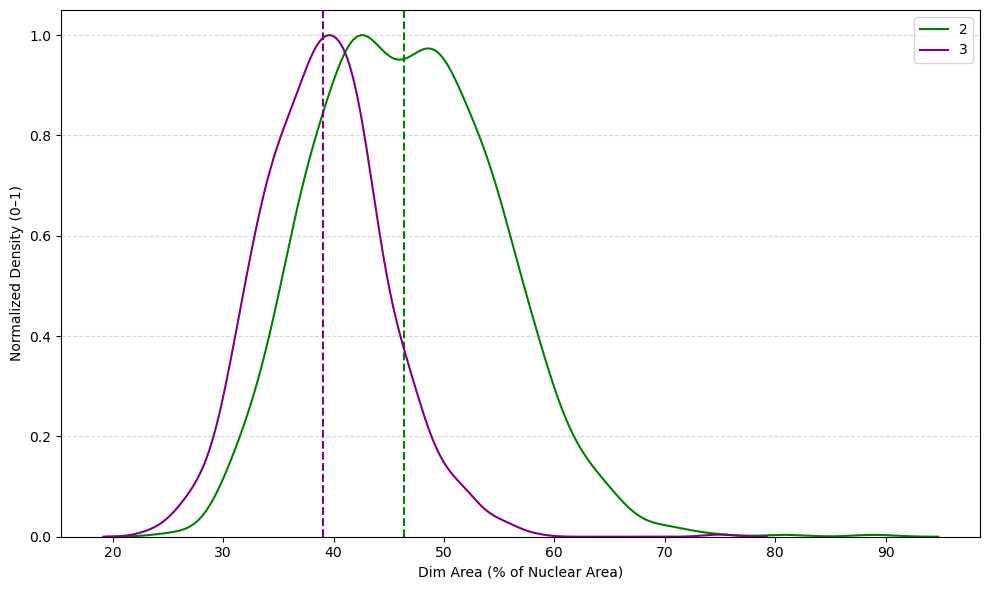

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
import seaborn as sns

root_dir = r"QUAC_images_protein_0/H3K4me1/train"

# --- Compute dim area percentages ---
dim_areas = {}
subset_classes = {"19", "22"}    # folder names to plot
rename_map = {"19": "2", "22": "3"}   # corresponding classes

for subfolder in sorted(os.listdir(root_dir)):
    if subfolder not in subset_classes:
        continue

    class_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(class_path):
        continue

    dim_areas[subfolder] = []

    for filename in os.listdir(class_path):
        if not filename.lower().endswith(".tiff"):
            continue

        img_path = os.path.join(class_path, filename)
        img = io.imread(img_path).astype(float)
        nonzero_mask = img > 0
        nonzero_pixels = img[nonzero_mask]

        if len(nonzero_pixels) > 0:
            otsu_thresh = filters.threshold_otsu(nonzero_pixels)
        else:
            otsu_thresh = 0

        dim_mask = (img < otsu_thresh) & nonzero_mask
        nuclear_area = np.sum(nonzero_mask)
        dim_area = np.sum(dim_mask)
        dim_percentage = (dim_area / nuclear_area) * 100 if nuclear_area > 0 else 0
        dim_areas[subfolder].append(dim_percentage)

    print(f"Processed class {subfolder}: {len(dim_areas[subfolder])} cells")

# --- Plot normalized KDEs ---
plt.figure(figsize=(10,6))
colors = ["green", "purple"]

for i, cls in enumerate(sorted(dim_areas.keys())):
    counts = dim_areas[cls]
    if len(counts) == 0:
        continue

    plot_label = rename_map.get(cls, cls)   # <<< renamed label

    # Get KDE curve
    kde = sns.kdeplot(counts, label=plot_label, color=colors[i], fill=False)
    x_data = kde.get_lines()[-1].get_xdata()
    y_data = kde.get_lines()[-1].get_ydata()

    # Normalize this curve’s y values to 0–1
    y_data_norm = y_data / np.max(y_data)

    # Remove original line and re-plot normalized
    kde.get_lines()[-1].remove()
    plt.plot(x_data, y_data_norm, color=colors[i], label=plot_label)

    # Plot median as dashed line
    median_val = np.median(counts)
    plt.axvline(median_val, color=colors[i % len(colors)], linestyle='--')

plt.xlabel("Dim Area (% of Nuclear Area)")
plt.ylabel("Normalized Density (0–1)")
# plt.title("Normalized Distribution of Dim Area for H3K4me1 (Classes 2 & 3)")
plt.legend()
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("H3K4me1_distribution.pdf", dpi=300)
plt.show()


In [5]:
from scipy.stats import kruskal, mannwhitneyu
import itertools

# Overall Kruskal–Wallis test 
group_values = [v for v in dim_areas.values() if len(v) > 0]
class_names = [k for k, v in dim_areas.items() if len(v) > 0]

stat, p = kruskal(*group_values)
print(f"Kruskal–Wallis H-statistic: {stat:.3f}, p-value: {p:.3e}")

# Pairwise Mann–Whitney U tests between classes
print("\nPairwise Mann–Whitney U tests:")
for (cls1, cls2) in itertools.combinations(class_names, 2):
    data1, data2 = np.array(dim_areas[cls1]), np.array(dim_areas[cls2])
    if len(data1) > 0 and len(data2) > 0:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        print(f"{cls1} vs {cls2}: U={stat:.2f}, p={p:.3e}")

Kruskal–Wallis H-statistic: 491.980, p-value: 5.285e-109

Pairwise Mann–Whitney U tests:
19 vs 22: U=928513.00, p=5.289e-109
